In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
#sys.path.insert(0, '/Users/kvolk/Documents/GitHub/SBDynT/src')
sys.path.insert(0, '../src')
import run_reb
import rebound
import numpy as np
import horizons_api
import tools

import scipy.signal as signal


%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["figure.titlesize"] = 25

# First, an example of filtering an idealized signal

In [2]:
dt = 10

sig = np.arange(0,1e5,dt)
#three modes, g1 is "free/proper" and g2/g3 are "planets"

g1 = 2*np.pi/1e4
g2=2*np.pi/2e3
g3 = 2*np.pi/5e4

proper = 2.*np.sin(times*g1+0.287)
sig = 2.*np.sin(times*g1+0.287) + 0.5*np.sin(times*g2+2.37) + 3*np.sin(times*g3+1.37)
planet = 2.5*np.sin(times*g2+2.37)
planet2 = 1*np.sin(times*g3+1.37)

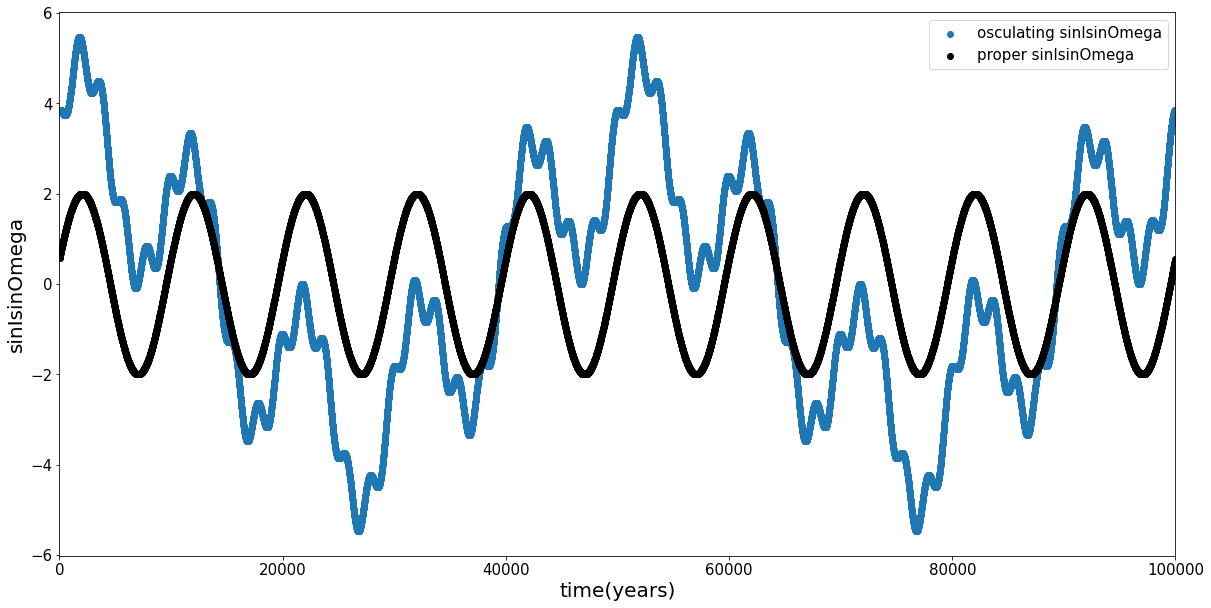

In [3]:
plt.scatter(times,sig,label='osculating sinIsinOmega');
plt.scatter(times,proper, label='proper sinIsinOmega',c='k');
plt.legend();
plt.xlabel('time(years)');

plt.ylabel('sinIsinOmega');
plt.xlim([0,1e5]);

calculate and plot FFT power spectrum and lombscargle power spectrum

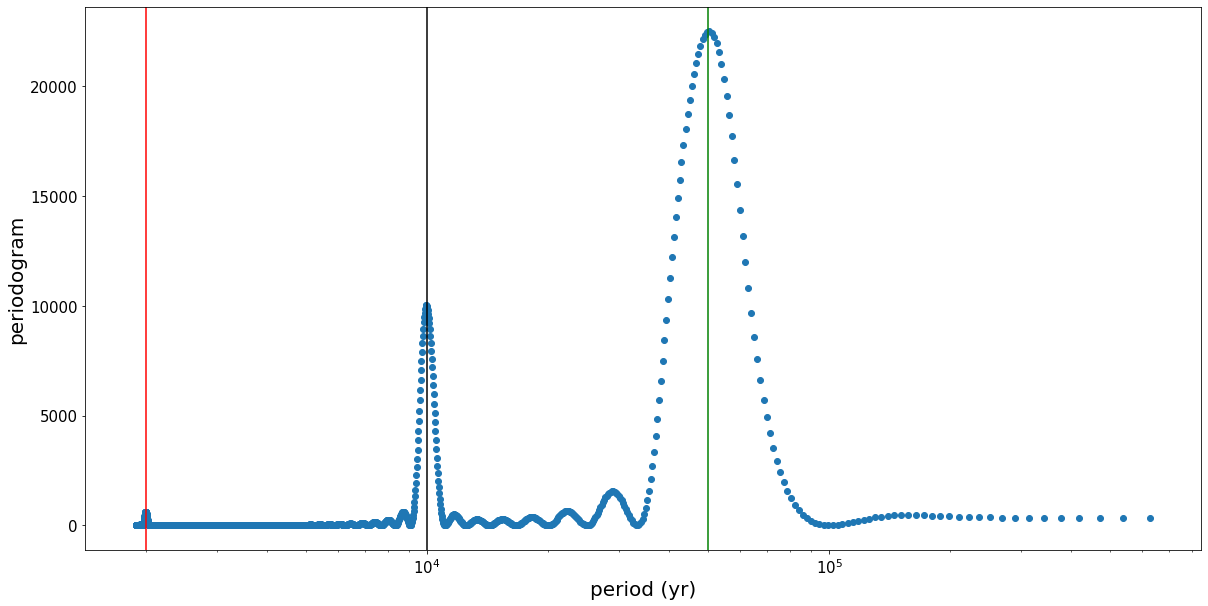

In [4]:
#define the frequency range of interest
fs = np.linspace(1e-5,3.333e-3,2000);
#calculate and plot the periodigram
pgram = signal.lombscargle(times, sig, fs, normalize=False);
plt.xscale('log');
plt.scatter(2.*np.pi/fs,pgram);
plt.axvline(x=2.*np.pi/g1,c='k');
plt.axvline(x=2.*np.pi/g2,c='r');
plt.axvline(x=2.*np.pi/g3,c='g');
plt.xlabel('period (yr)');
plt.ylabel('periodogram');

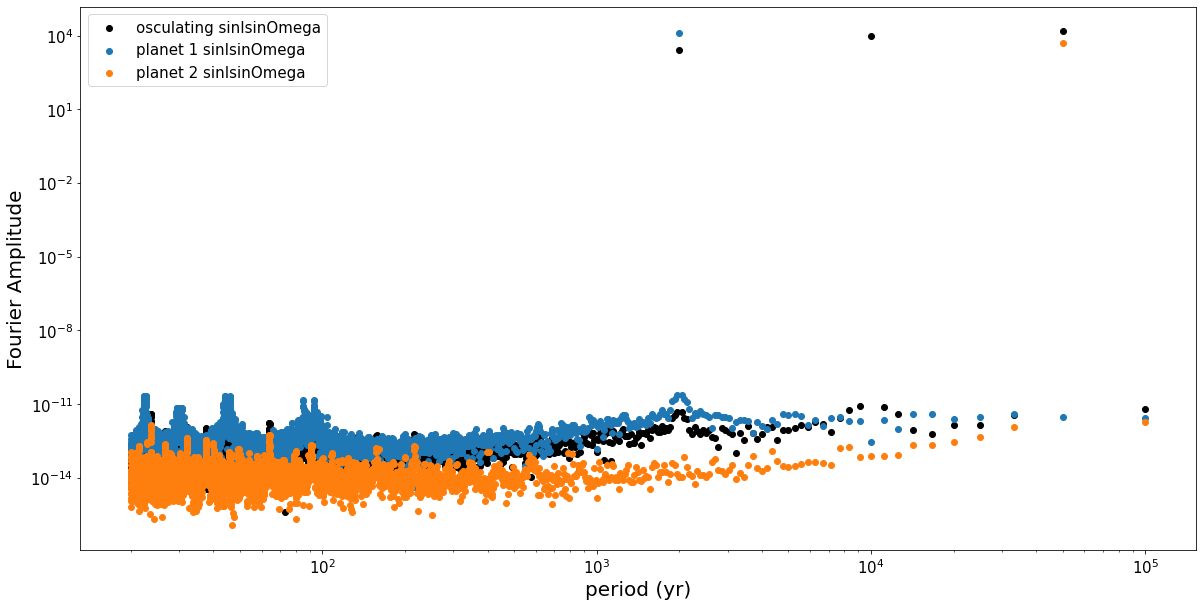

In [6]:
#calculate and plot the FFT power spectrum
n = len(sig)
#set of frequencies in the FFT
freq = np.fft.rfftfreq(n,d=dt)
#FFT
Y = np.fft.rfft(sig)

#FFTs of the "planets"
YP1 = np.fft.rfft(planet)
YP2 = np.fft.rfft(planet2)

#translate to power 
pY = (np.abs(Y))
pYP1 = (np.abs(YP1))
pYP2 = (np.abs(YP2))

#plot the power spectrum (leaving off the frequency=0 term))
plt.scatter(1./freq[1:],pY[1:],label='osculating sinIsinOmega',c='k');
plt.scatter(1./freq[1:],pYP1[1:],label='planet 1 sinIsinOmega');
plt.scatter(1./freq[1:],pYP2[1:],label='planet 2 sinIsinOmega');
plt.legend();

plt.xlabel('period (yr)');
plt.ylabel('Fourier Amplitude');
plt.xscale('log');
plt.yscale('log');

Do a really simple filtering procedure to zero out the "planet" frequencies

for planet 1, removing period 2000.000000
for planet 2, removing period 50000.000000


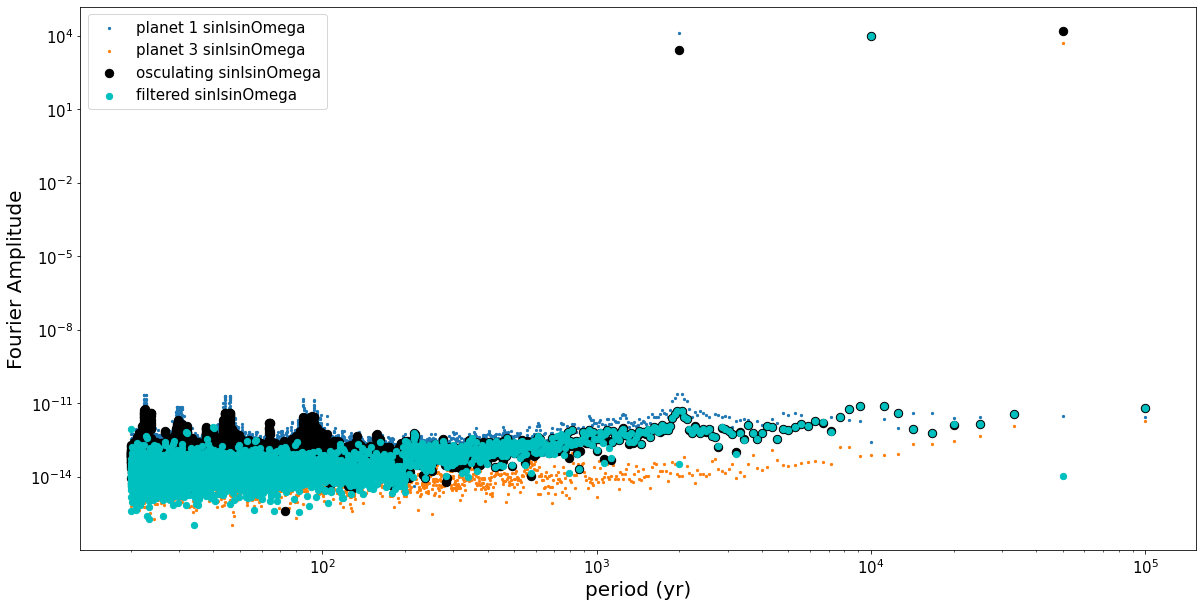

In [7]:
#calculate the peak power in the planets spectra (ignoring freq=0)
P1max = pYP1[1:].max()
P2max = pYP2[1:].max()
#index of these
ip1max = np.argmax(pYP1[1:])+1
ip2max = np.argmax(pYP2[1:])+1



print("for planet 1, removing period %f" % (1./freq[ip1max]))
print("for planet 2, removing period %f" % (1./freq[ip2max]))

#make a copy of the particle's FFT
filtered_Y = Y.copy()
#zero out the terms where the planets' spectra have power
#above some threshold (10% here)
#and zero out frequencies above some threshold
freqlim = 1./200.
pth = 0.1
imax = len(Y)
for i in range(0,imax):
    if(pYP1[i]>0.1*P1max or pYP2[i]>0.1*P2max or freq[i]>freqlim):
        filtered_Y[i]=0

#inverse FFT to reconstruct the filtered signal
sig_filtered = np.fft.irfft(filtered_Y)

#recalculate and plot power spectrum from the filtered signal
Yf = np.fft.rfft(sig_filtered)
pYf = (np.abs(Yf))


#plot the power spectrum (leaving off the frequency=0 term))
plt.scatter(1./freq[1:],pYP1[1:],label='planet 1 sinIsinOmega',s=5);
plt.scatter(1./freq[1:],pYP2[1:],label='planet 3 sinIsinOmega',s=5);
plt.scatter(1./freq[1:],pY[1:],label='osculating sinIsinOmega',c='k',s=70);
plt.scatter(1./freq[1:],pYf[1:],label='filtered sinIsinOmega',c='c',s=40);

plt.legend();

plt.xlabel('period (yr)');
plt.ylabel('Fourier Amplitude');
plt.xscale('log');
plt.yscale('log');




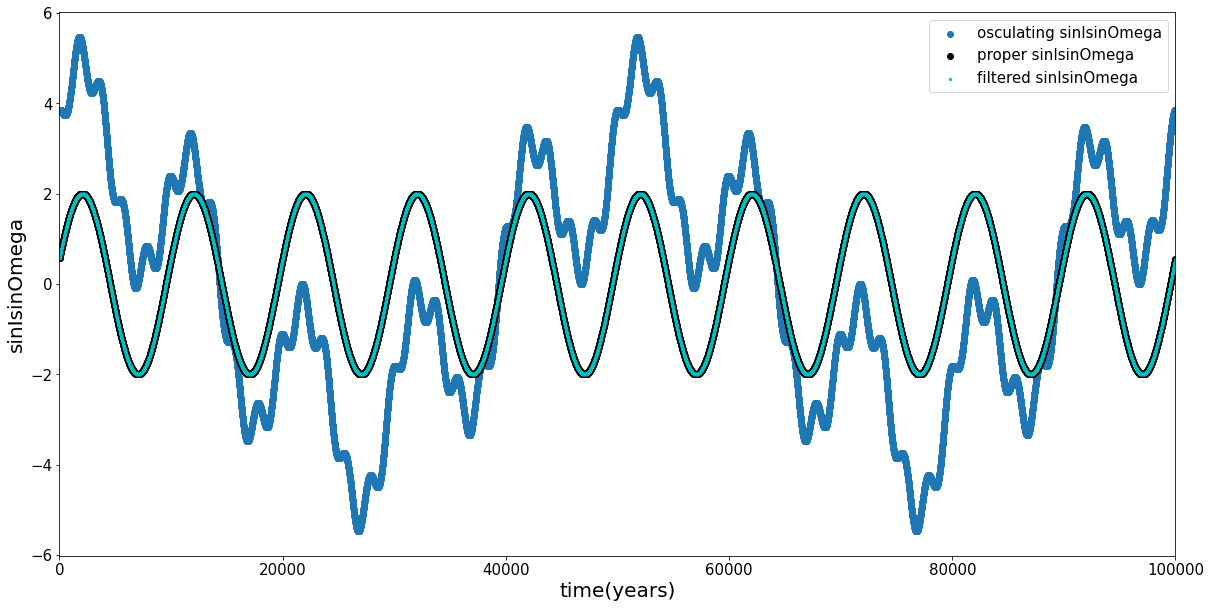

In [8]:
plt.scatter(times,sig,label='osculating sinIsinOmega');
plt.scatter(times,proper,c='k',label='proper sinIsinOmega');
plt.scatter(times,sig_filtered,s=5,c='c',label='filtered sinIsinOmega');
plt.legend();
plt.xlabel('time(years)');

plt.ylabel('sinIsinOmega');
plt.xlim([0,1e5]);

# Working with actual data

read in data for a classical belt object I'm sure isn't in or super close to a  mean motion resonance

In [249]:
#(keep the space in sbody, it's a typo from when I ran it, but the hash has the space)\
#this will take a while, it's a 100 Myr integration with a 500 year output cadence
sbody = '2001 FO185'
objname = '2001FO185'
dt=500.
#path = 'Asteroids/'+objname
path = 'TNOs/'+objname

#these arrays are all a bit of a mess, at some point would want to 
#change it to be a multi-dimensional array for the planets so they 
#don't all have to be handled by hand
a = np.zeros(1);e = np.zeros(1);inc = np.zeros(1);
p = np.zeros(1);q = np.zeros(1);h = np.zeros(1);k = np.zeros(1);
pu = np.zeros(1);qu = np.zeros(1);hu = np.zeros(1);ku = np.zeros(1);
pj = np.zeros(1);qj = np.zeros(1);hj = np.zeros(1);kj = np.zeros(1);
ps = np.zeros(1);qs = np.zeros(1);hs = np.zeros(1);ks = np.zeros(1);
pn = np.zeros(1);qn = np.zeros(1);hn = np.zeros(1);kn = np.zeros(1);
omega = np.zeros(1);
Omega = np.zeros(1);
M = np.zeros(1)
t = np.zeros(1);
#sa = rebound.SimulationArchive(path+"/archive.bin")
#sa = pd.read_csv(path+"/series_new.csv")
#print("start time %f" % sa.tmin)
#print("stop time %f" % sa.tmax)
'''
sim=sa[-1]
print(sim)
print(sim.particles)

planets = ['jupiter','saturn','uranus','neptune']
for i,sim in enumerate(sa):
    tp = sim.particles[sbody+"_bf"]
    nep = sim.particles["neptune"]
    ura = sim.particles["uranus"]
    sat = sim.particles["saturn"]
    jup = sim.particles["jupiter"]
    com = sim.calculate_com()
    o = tp.calculate_orbit(com)
    
    onep = nep.calculate_orbit(com)
    oura = ura.calculate_orbit(com)
    osat = sat.calculate_orbit(com)
    ojup = jup.calculate_orbit(com)

    t = np.append(t, sim.t)
    a = np.append(a, o.a)
    p = np.append(p, np.sin(o.inc)*np.sin(o.Omega))
    q = np.append(q, np.sin(o.inc)*np.cos(o.Omega))
    h = np.append(h, (o.e)*np.sin(o.Omega+o.omega))
    k = np.append(k, (o.e)*np.cos(o.Omega+o.omega))

    pj = np.append(pj, np.sin(ojup.inc)*np.sin(ojup.Omega))
    qj = np.append(qj, np.sin(ojup.inc)*np.cos(ojup.Omega))
    hj = np.append(hj, (ojup.e)*np.sin(ojup.Omega+ojup.omega))
    kj = np.append(kj, (ojup.e)*np.cos(ojup.Omega+ojup.omega))

    ps = np.append(ps, np.sin(osat.inc)*np.sin(osat.Omega))
    qs = np.append(qs, np.sin(osat.inc)*np.cos(osat.Omega))
    hs = np.append(hs, (osat.e)*np.sin(osat.Omega+osat.omega))
    ks = np.append(ks, (osat.e)*np.cos(osat.Omega+osat.omega))

    pu = np.append(pu, np.sin(oura.inc)*np.sin(oura.Omega))
    qu = np.append(qu, np.sin(oura.inc)*np.cos(oura.Omega))
    hu = np.append(hu, (oura.e)*np.sin(oura.Omega+oura.omega))
    ku = np.append(ku, (oura.e)*np.cos(oura.Omega+oura.omega))

    pn = np.append(pn, np.sin(onep.inc)*np.sin(onep.Omega))
    qn = np.append(qn, np.sin(onep.inc)*np.cos(onep.Omega))
    hn = np.append(hn, (onep.e)*np.sin(onep.Omega+onep.omega))
    kn = np.append(kn, (onep.e)*np.cos(onep.Omega+onep.omega))


    e = np.append(e, o.e)
    omega = np.append(omega, o.omega*180/np.pi)
    Omega = np.append(Omega, o.Omega*180/np.pi)
    M = np.append(M, o.M*180/np.pi)
    
    inc = np.append(inc, o.inc*180/np.pi)

'''
series = pd.read_csv(path+'/series.csv')
t = series['t'].values
a = series['a'].values
e = series['e'].values
inc = series['inc'].values
omega = series['omega'].values
Omega = series['Omega'].values
M = series['M'].values
h = np.sin(inc)*np.sin(Omega)
k = np.sin(inc)*np.cos(Omega)
p = e*np.sin(Omega+omega)
q = e*np.cos(Omega+omega)

hj = np.delete(hj,0)
kj = np.delete(kj,0)
pj = np.sin
qj = np.delete(qj,0)

 pj = np.append(pj, np.sin(ojup.inc)*np.sin(ojup.Omega))
    qj = np.append(qj, np.sin(ojup.inc)*np.cos(ojup.Omega))
    hj = np.append(hj, (ojup.e)*np.sin(ojup.Omega+ojup.omega))
    kj = np.append(kj, (ojup.e)*np.cos(ojup.Omega+ojup.omega))
'''

t = np.delete(t,0)
a = np.delete(a,0)
e = np.delete(e,0)
inc = np.delete(inc,0)
omega = np.delete(omega,0)
Omega = np.delete(Omega,0)
M = np.delete(M,0)
h = np.delete(h,0)
k = np.delete(k,0)
p = np.delete(p,0)
q = np.delete(q,0)
'''
series = pd.DataFrame(columns=['t','a','e','inc','omega','Omega','M','h','k','p','q','hj','kj','qj','pj','hs','ks','qs','ps','hu','ku','qu','pu','hn','kn','qn','pn'])

series['t'] = t
series['a'] = a
series['e'] = e
series['inc'] = inc
series['omega'] = omega
series['Omega'] = Omega
series['M'] = M
series['h'] = h
series['k'] = k
series['p'] = p
series['q'] = q

'''
np.savetxt(path+'/t.csv',t)
np.savetxt(path+'/a.csv',a)
np.savetxt(path+'/e.csv',e)
np.savetxt(path+'/inc.csv',inc)
np.savetxt(path+'/omega.csv',omega)
np.savetxt(path+'/Omega.csv',Omega)
np.savetxt(path+'/M.csv',M)
np.savetxt(path+'/h.csv',h)
np.savetxt(path+'/k.csv',k)
np.savetxt(path+'/q.csv',q)
np.savetxt(path+'/p.csv',p)
'''
hj = np.delete(hj,0)
kj = np.delete(kj,0)
pj = np.delete(pj,0)
qj = np.delete(qj,0)
hs = np.delete(hs,0)
ks = np.delete(ks,0)
ps = np.delete(ps,0)
qs = np.delete(qs,0)
hu = np.delete(hu,0)
ku = np.delete(ku,0)
pu = np.delete(pu,0)
qu = np.delete(qu,0)
hn = np.delete(hn,0)
kn = np.delete(kn,0)
pn = np.delete(pn,0)
qn = np.delete(qn,0)

series['hj'] = hj
series['hs'] = hs
series['hu'] = hu
series['hn'] = hn
series['kj'] = kj
series['ks'] = ks
series['ku'] = ku
series['kn'] = kn
series['pj'] = pj
series['ps'] = ps
series['pu'] = pu
series['pn'] = pn
series['qj'] = qj
series['qs'] = qs
series['qu'] = qu
series['qn'] = qn

series.to_csv(path+'/series_new.csv')

'''
np.savetxt(path+'/hj.csv',hj)
np.savetxt(path+'/hs.csv',hs)
np.savetxt(path+'/hu.csv',hu)
np.savetxt(path+'/hn.csv',hn)
np.savetxt(path+'/kj.csv',kj)
np.savetxt(path+'/ks.csv',ks)
np.savetxt(path+'/ku.csv',ku)
np.savetxt(path+'/kn.csv',kn)
np.savetxt(path+'/qj.csv',qj)
np.savetxt(path+'/qs.csv',qs)
np.savetxt(path+'/qu.csv',qu)
np.savetxt(path+'/qn.csv',qn)
np.savetxt(path+'/pj.csv',pj)
np.savetxt(path+'/ps.csv',ps)
np.savetxt(path+'/pu.csv',pu)
np.savetxt(path+'/pn.csv',pn)'''


AttributeError: 'DataFrame' object has no attribute 'tmin'

In [253]:
series = pd.read_csv(path+'/series_new.csv')

t = series['t'].values
a = series['a'].values
e = series['e'].values
inc = series['inc'].values
omega = series['omega'].values
Omega = series['Omega'].values
M = series['M'].values
h = np.sin(inc)*np.sin(Omega)
k = np.sin(inc)*np.cos(Omega)
p = e*np.sin(Omega+omega)
q = e*np.cos(Omega+omega)

hj = series['hj'].values
kj = series['kj'].values
pj = series['pj'].values
qj = series['qj'].values

hs = series['hs'].values
ks = series['ks'].values
ps = series['ps'].values
qs = series['qs'].values

hn = series['hn'].values
kn = series['kn'].values
pn = series['pn'].values
qn = series['qn'].values

hu = series['hu'].values
ku = series['ku'].values
pu = series['pu'].values
qu = series['qu'].values


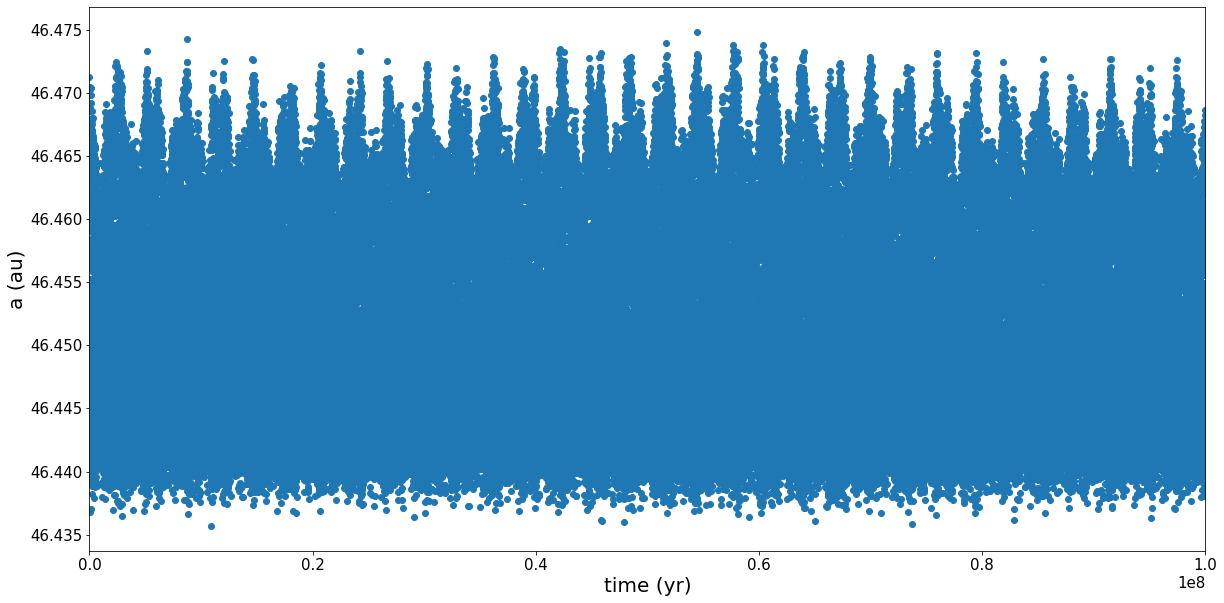

In [172]:
plt.scatter(t,a);
plt.ylabel('a (au)');
plt.xlabel('time (yr)');
plt.xlim([0,t[-1]]);


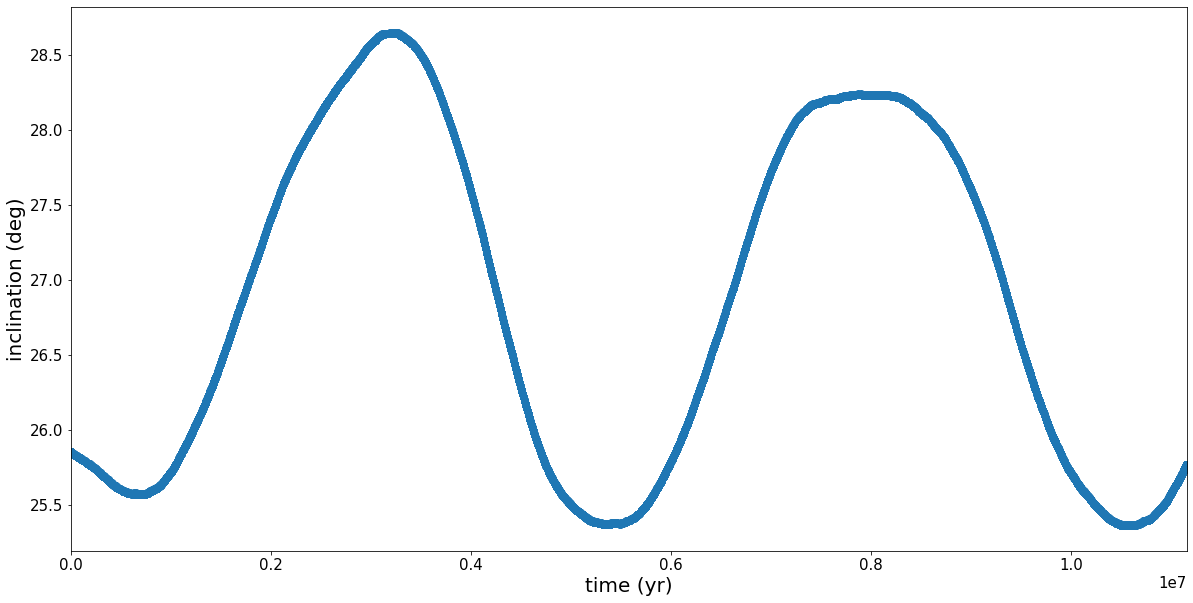

In [14]:
plt.scatter(t,inc);
plt.ylabel('inclination (deg)');
plt.xlabel('time (yr)');
plt.xlim([0,t[-1]]);

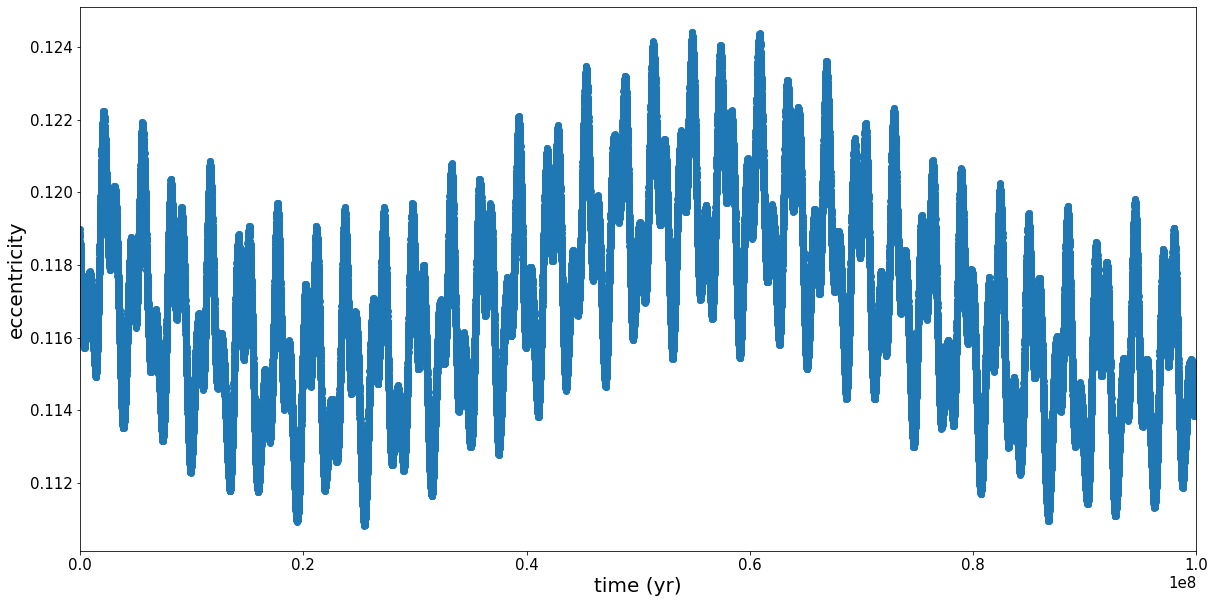

In [173]:
plt.scatter(t,e);
plt.ylabel('eccentricity');
plt.xlabel('time (yr)');
plt.xlim([0,t[-1]]);

do all the FFTs for the inclination and eccentricity vectors

In [254]:
#set up all the FFT power spectra, etc
#the outputs are not exact, but it's about 

n = len(h)
freq = np.fft.rfftfreq(n,d=dt)

#particle eccentricity vectors
Yh= np.fft.rfft(h)
Yk = np.fft.rfft(k)

#giant planets
Yhu = np.fft.rfft(hu)
Yhj = np.fft.rfft(hj)
Yhn = np.fft.rfft(hn)
Yhs = np.fft.rfft(hs)
Yku = np.fft.rfft(ku)
Ykj = np.fft.rfft(kj)
Ykn = np.fft.rfft(kn)
Yks = np.fft.rfft(ks)

#convert to power
pYh = np.abs(Yh)
pYk = np.abs(Yk)
pYhu = np.abs(Yhu)
pYhn = np.abs(Yhn)
pYhj = np.abs(Yhj)
pYhs = np.abs(Yhs)
pYku = np.abs(Yku)
pYkn = np.abs(Ykn)
pYkj = np.abs(Ykj)
pYks = np.abs(Yks)


#find the max power and indexes of that max power
#(disregarding the frequency=0 terms)
kumax = pYku[1:].max()
knmax = pYkn[1:].max()
ksmax = pYks[1:].max()
kjmax = pYkj[1:].max()
humax = pYhu[1:].max()
hnmax = pYhn[1:].max()
hsmax = pYhs[1:].max()
hjmax = pYhj[1:].max()

#(these need the plus 1 to account for neglecting the f=0 term)
ihumax = np.argmax(pYhu[1:])+1
ihnmax = np.argmax(pYhn[1:])+1 
ihsmax = np.argmax(pYhs[1:])+1 
ihjmax = np.argmax(pYhj[1:])+1 
ikumax = np.argmax(pYku[1:])+1 
iknmax = np.argmax(pYkn[1:])+1
iksmax = np.argmax(pYks[1:])+1
ikjmax = np.argmax(pYkj[1:])+1 



#particle inclination vectors
Yp= np.fft.rfft(p)
Yq = np.fft.rfft(q)
#giant planets
Ypu = np.fft.rfft(pu)
Ypj = np.fft.rfft(pj)
Ypn = np.fft.rfft(pn)
Yps = np.fft.rfft(ps)
Yqu = np.fft.rfft(qu)
Yqj = np.fft.rfft(qj)
Yqn = np.fft.rfft(qn)
Yqs = np.fft.rfft(qs)

#convert to power
pYp = np.abs(Yp)
pYpu = np.abs(Ypu)
pYpn = np.abs(Ypn)
pYpj = np.abs(Ypj)
pYps = np.abs(Yps)
pYqu = np.abs(Yqu)
pYqn = np.abs(Yqn)
pYqj = np.abs(Yqj)
pYqs = np.abs(Yqs)




#find the max power and indexes of that max power
#(disregarding the frequency=0 terms)
pumax = pYpu[1:].max()
pnmax = pYpn[1:].max()
psmax = pYps[1:].max()
pjmax = pYpj[1:].max()
qumax = pYqu[1:].max()
qnmax = pYqn[1:].max()
qsmax = pYqs[1:].max()
qjmax = pYqj[1:].max()


ipumax = np.argmax(pYpu[1:])+1
ipnmax = np.argmax(pYpn[1:])+1 
ipsmax = np.argmax(pYps[1:])+1 
ipjmax = np.argmax(pYpj[1:])+1 
iqumax = np.argmax(pYqu[1:])+1 
iqnmax = np.argmax(pYqn[1:])+1
iqsmax = np.argmax(pYqs[1:])+1
iqjmax = np.argmax(pYqj[1:])+1 


print("peak planet eccentricity periods (years):")
print("Jupiter %f" % (1/freq[ikjmax]))
print("Saturn %f" % (1/freq[iksmax]))
print("Uranus %f" % (1/freq[ikumax]))
print("Neptune %f" % (1/freq[iknmax]))




peak planet eccentricity periods (years):
Jupiter 305811.926606
Saturn 45892.840753
Uranus 420170.168067
Neptune 1923086.538462


100001
100001


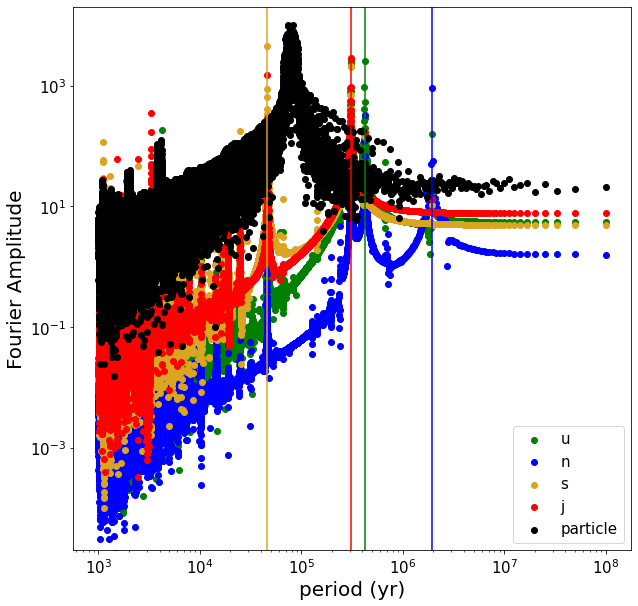

200001
200001 10355.15818761012


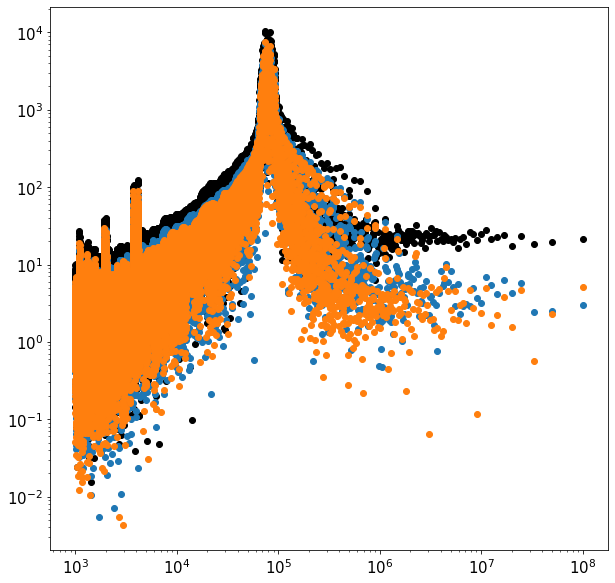

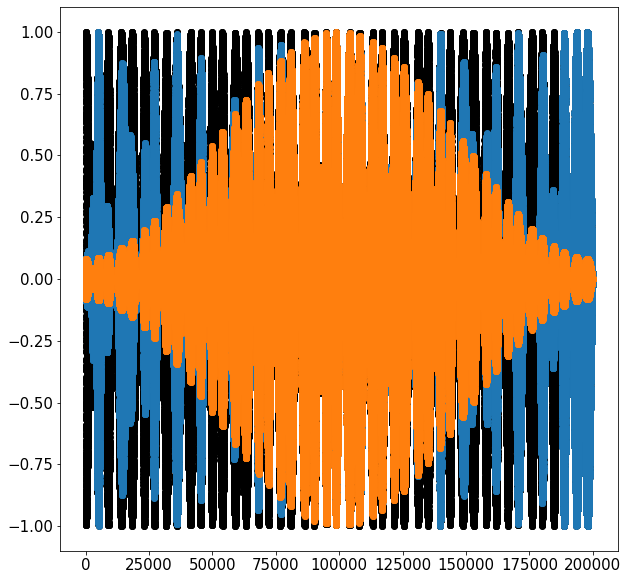

'\ndt=10\nfs = np.linspace(1e-5,3.333e-3,2000);\ntimes = np.arange(0,len(h),dt)\npgram = signal.lombscargle(t, h, freq[1:], normalize=False);\nplt.plot(pgram)\n'

In [314]:
#plot the eccentricity spectra
import scipy
print(len(freq))
print(len(pYhu))
plt.scatter(1/freq[1:],pYhu[1:],label='u',c='g')
plt.scatter(1/freq[1:],pYhn[1:],label='n',c='b')
plt.scatter(1/freq[1:],pYhs[1:],label='s',c='goldenrod')
plt.scatter(1/freq[1:],pYhj[1:],label='j',c='r')
plt.scatter(1/freq[1:],pYh[1:],label='particle',c='k')

plt.axvline(x=1/freq[ihumax],c='g')
plt.axvline(x=1/freq[ihjmax],c='r')
plt.axvline(x=1/freq[ihsmax],c='goldenrod')
plt.axvline(x=1/freq[ihnmax],c='b')

plt.legend(loc='lower right')

plt.xlabel('period (yr)')
plt.ylabel('Fourier Amplitude')
plt.yscale('log')
plt.xscale('log')
maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

plt.ylim([0.00002,2*maxp]);
plt.show()

M = 200001
M = int(pYh[1:].max())
hamming = scipy.signal.windows.hamming(M)

hamming2 = scipy.signal.windows.hamming(200001)
print(len(h))

pYh = np.abs(np.fft.rfft(h))


newh = h.copy()
print(len(h),pYh[1:].max())
for i in range(int(len(h)/M)-1):
    #print(i)
    newh[int(i*M):int((i+1)*M)] = hamming*newh[int(i*M):int((i+1)*M)]
newh2 = hamming2*h
new_Yh2 = np.fft.rfft(newh2)
new_pYh2 = np.abs(new_Yh2)
new_Yh = np.fft.rfft(newh)
new_pYh = np.abs(new_Yh)

plt.scatter(1/freq[1:],pYh[1:],label='particle',c='k')
plt.scatter(1/freq[1:],new_pYh[1:],label='particle hamm')
plt.scatter(1/freq[1:],new_pYh2[1:],label='particle hamm 2')
#plt.scatter(1/freq[1:],[1:],label='window',c='r')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.scatter(range(len(h)-1),h[1:],label='particle',c='k')
plt.scatter(range(len(h)-1),newh[1:],label='particle hamm')
plt.scatter(range(len(h)-1),newh2[1:],label='particle hamm')
#plt.scatter(1/freq[1:],hamming[1:],label='window',c='r')
#plt.xscale('log')
#plt.yscale('log')
plt.show()
'''
dt=10
fs = np.linspace(1e-5,3.333e-3,2000);
times = np.arange(0,len(h),dt)
pgram = signal.lombscargle(t, h, freq[1:], normalize=False);
plt.plot(pgram)
'''

In [295]:
dt=10
fs = np.linspace(1e-5,3.333e-3,2000);
times = np.arange(0,len(h),dt)
from astropy.timeseries import LombScargle
frequency, power = LombScargle(t, h).autopower()
pgram = signal.lombscargle(t, h, freq[1:]*2*np.pi, normalize=False);

2000 100000


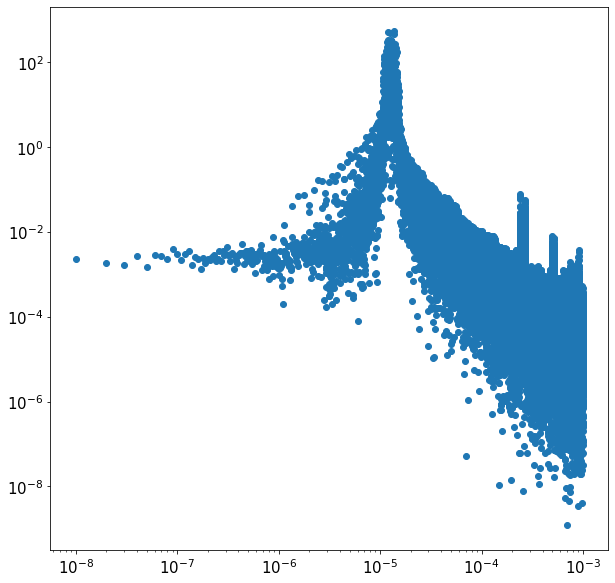

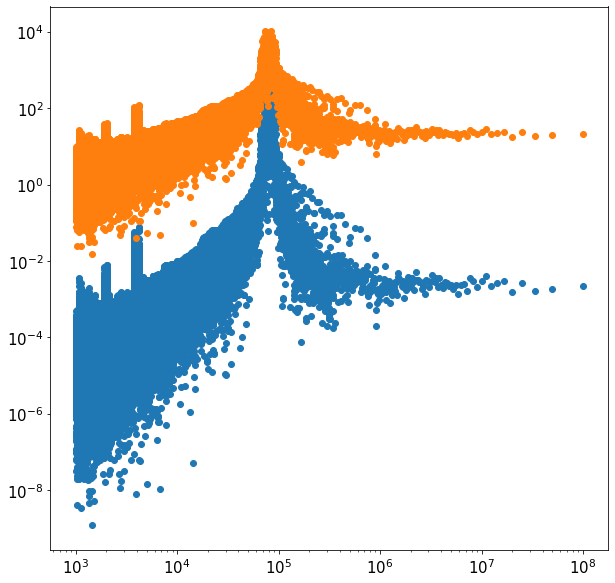

200001 100000


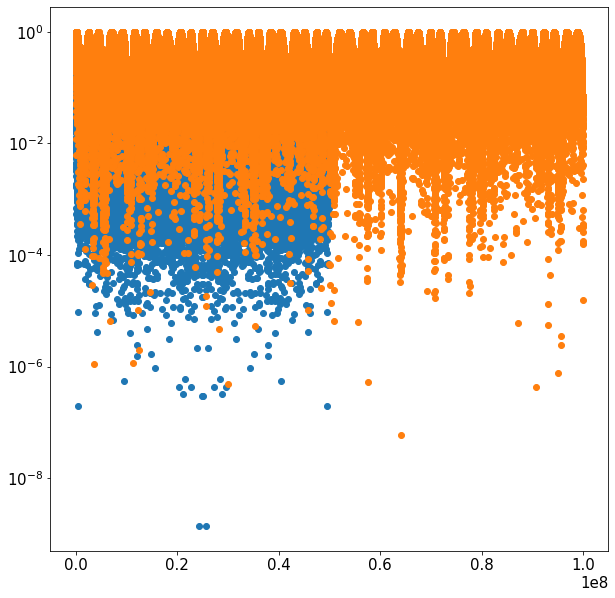

In [296]:
print(len(fs),len(pgram))
plt.scatter(freq[1:],pgram)
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.scatter(1/freq[1:],pgram)
plt.scatter(1/freq[1:],pYh[1:])
plt.xscale('log')
plt.yscale('log')
plt.show()
r_ls = np.fft.ifft(pgram)
newt = np.fft.ifft(np.fft.rfft(t))
print(len(t),len(r_ls))
plt.scatter(t[:100000],r_ls)
plt.scatter(t,h)
plt.yscale('log')
plt.show()

100001


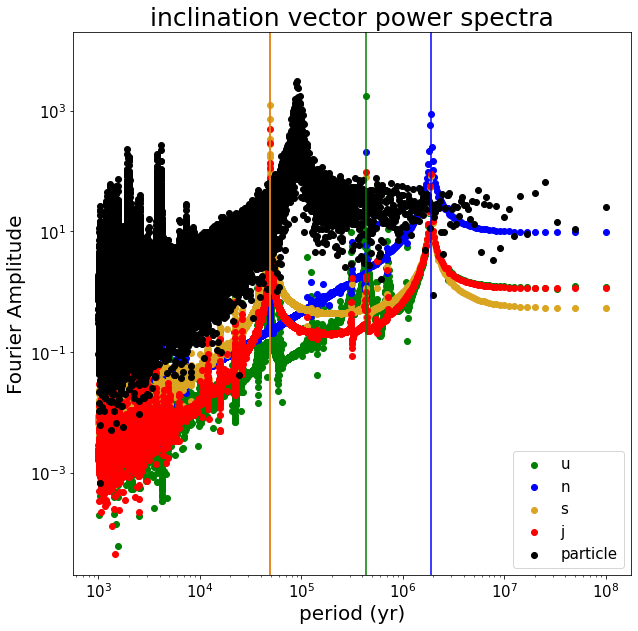

In [260]:
#plot the inclination spectra

print(len(pYpj))
plt.scatter(1/freq[1:],pYpu[1:],label='u',c='g')
plt.scatter(1/freq[1:],pYpn[1:],label='n',c='b')
plt.scatter(1/freq[1:],pYps[1:],label='s',c='goldenrod')
plt.scatter(1/freq[1:],pYpj[1:],label='j',c='r')
plt.scatter(1/freq[1:],pYp[1:],label='particle',c='k')
plt.title('inclination vector power spectra',fontsize=25)
plt.legend(loc='lower right')


plt.axvline(x=1/freq[ipumax],c='g')
plt.axvline(x=1/freq[ipjmax],c='r')
plt.axvline(x=1/freq[ipsmax],c='goldenrod')
plt.axvline(x=1/freq[ipnmax],c='b')

plt.xlabel('period (yr)')
plt.ylabel('Fourier Amplitude')
plt.yscale('log')
plt.xscale('log')
maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

plt.ylim([0.00002,2*maxp]);

try a simple filter to zero out the planet frequencies

In [177]:
#make copies of the FFT outputs
Yp_f = Yp.copy()
Yq_f = Yq.copy()
Yh_f = Yh.copy()
Yk_f = Yk.copy()

imax = len(Yp)
#disregard antyhing with a period shorter than 5000 years
freqlim = 1./5000.
#disregard frequencies for which any planet has power at higher than 10% the max
pth = 0.25

for i in range(0,imax-1):
    if (pYpu[i]>pth*pumax or pYpj[i]>pth*pjmax or pYps[i]>pth*psmax 
       or pYpn[i]>pth*pnmax or freq[i]>freqlim):
        Yp_f[i]=0
    if (pYqu[i]>pth*qumax or pYqj[i]>pth*qjmax or pYqs[i]>pth*qsmax 
       or pYqn[i]>pth*qnmax or freq[i]>freqlim):
        Yq_f[i]=0
    if (pYhu[i]>pth*humax or pYhj[i]>pth*hjmax or pYhs[i]>pth*hsmax 
       or pYhn[i]>pth*hnmax or freq[i]>freqlim):
        Yh_f[i]=0
    if (pYku[i]>pth*kumax or pYkj[i]>pth*kjmax or pYks[i]>pth*ksmax 
       or pYkn[i]>pth*knmax or freq[i]>freqlim):
        Yk_f[i]=0


    
p_f = np.fft.irfft(Yp_f,len(p))
q_f = np.fft.irfft(Yq_f,len(q))
h_f = np.fft.irfft(Yh_f,len(h))
k_f = np.fft.irfft(Yk_f,len(k))



sini = np.sqrt(p*p+q*q)
sini_f = np.sqrt(p_f*p_f + q_f*q_f)
ecc = np.sqrt(h*h+k*k)
ecc_f = np.sqrt(h_f*h_f + k_f*k_f)

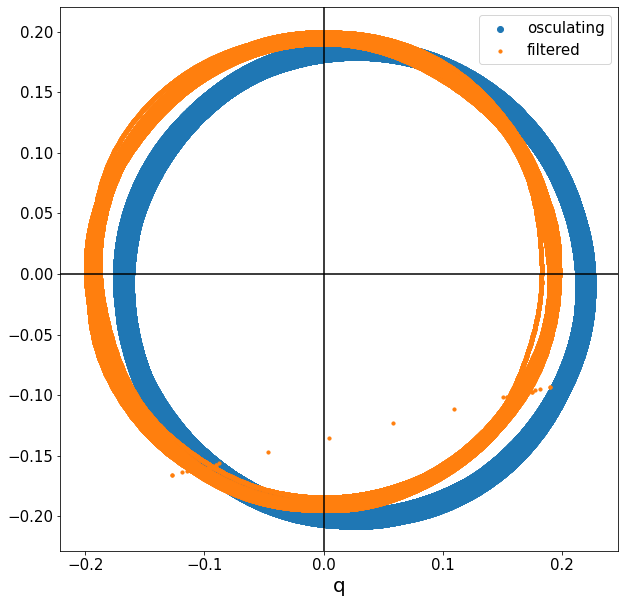

In [178]:
#plot p,q
#note: not sure why there are stray dots not on the circle
plt.rcParams["figure.figsize"] = (10, 10)
plt.scatter(p,q,label='osculating');
plt.scatter(p_f,q_f,s=10,label='filtered');
plt.axhline(y=0,c='k');
plt.axvline(x=0,c='k');
plt.xlabel('p');
plt.xlabel('q');
plt.legend();


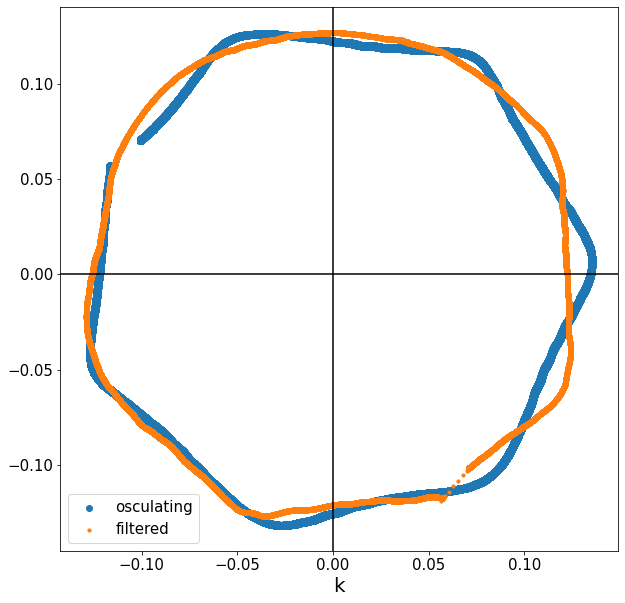

In [28]:
#plot h,k
#note: not sure why there are stray dots not on the circle
plt.scatter(h,k,label='osculating');
plt.scatter(h_f,k_f,s=10,label='filtered');
plt.axhline(y=0,c='k');
plt.axvline(x=0,c='k');
plt.xlabel('h');
plt.xlabel('k');
plt.legend();
plt.rcParams["figure.figsize"] = (20, 10)

the inclination filtering does get close-ish to the proper value, eccentricity one didn't do much of anything

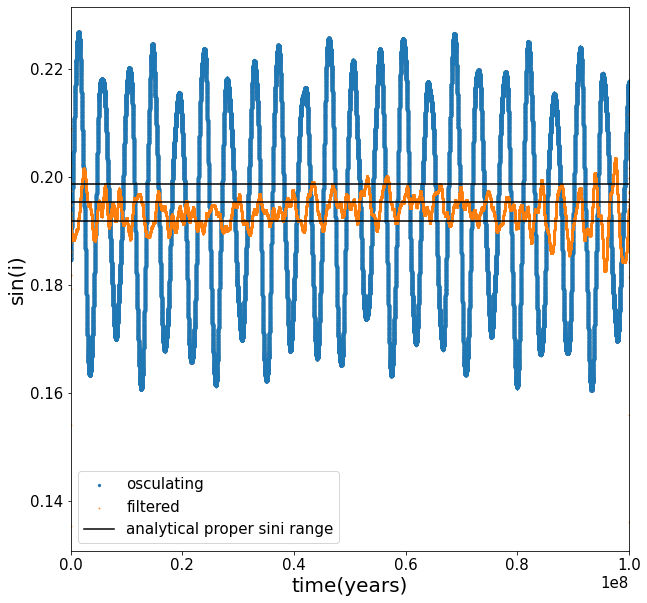

In [179]:
#plot oscuilating and filtered sini
plt.scatter(t,sini,s=5,label='osculating');
plt.scatter(t,sini_f,s=0.5,label='filtered');
#plot the range from Huang et al for this object
plt.axhline(y=np.sin(11.2669*np.pi/180),c='k',label='analytical proper sini range');
plt.axhline(y=np.sin(11.4669*np.pi/180),c='k');
plt.axhline(y=np.sin(11.0669*np.pi/180),c='k');
plt.xlabel('time(years)');
plt.ylabel('sin(i)');
plt.legend();

plt.xlim([0,t[-1]]);

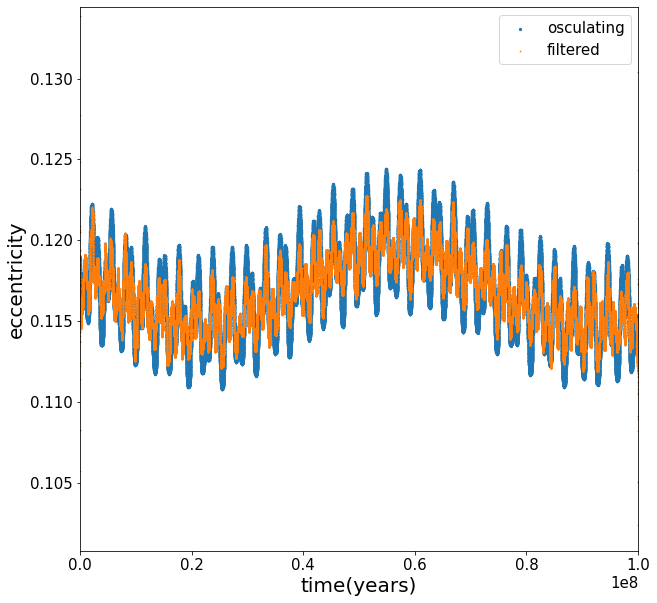

In [180]:
#plot oscuilating and filtered eccentrcicity
plt.scatter(t,ecc,s=5,label='osculating');
plt.scatter(t,ecc_f,s=0.5,label='filtered');

plt.xlabel('time(years)');
plt.ylabel('eccentricity');
plt.legend();

plt.xlim([0,t[-1]]);
plt.ylim([ecc.min()-0.01,ecc.max()+0.01]);

# below here are some random attempts with filters from the scipy signal package

1886801.8867924532


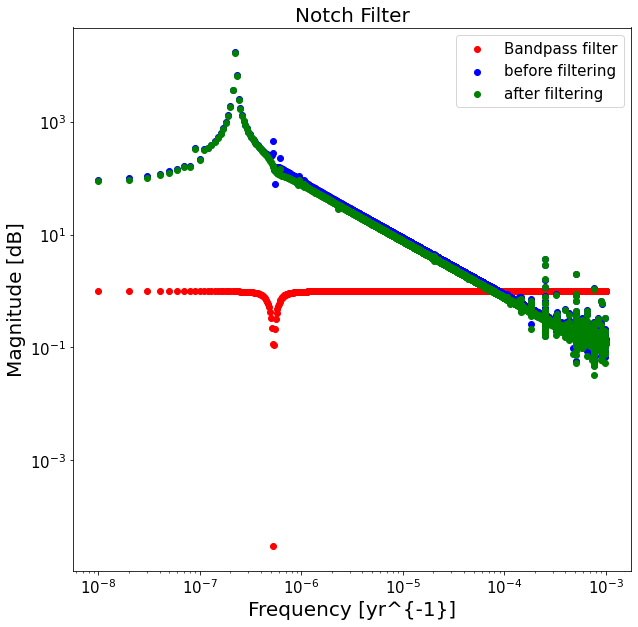

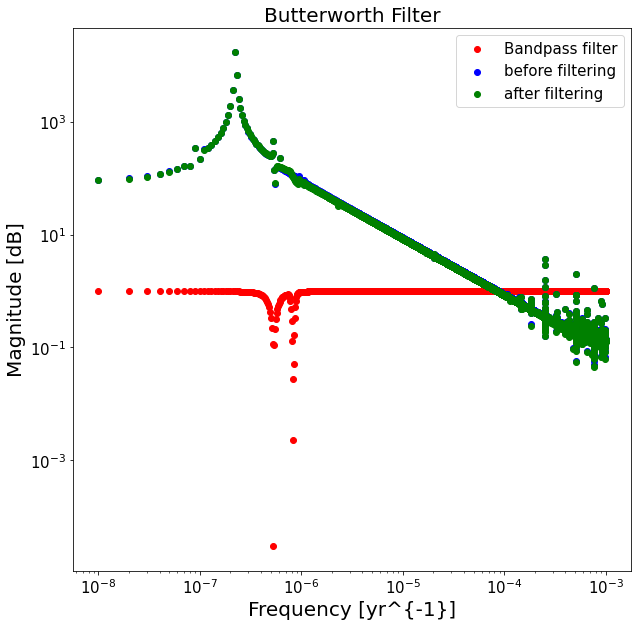

In [224]:

quality_factor = 3.
nmax = len(freq)
filt = freq[ipnmax]
print(1/freq[ipnmax])
fs = 1/500.

#Infinite Impulse Response Notch Filter
#Give the function a frequnecy to filter out and it will filter that specific frequency
b_f, a_f = signal.iirnotch(filt,quality_factor,fs=fs)

alt_f_p = signal.filtfilt(b_f, a_f, p)
alt_f_q = signal.filtfilt(b_f, a_f, q)

tY = np.fft.rfft(alt_f_p)
ptY = np.abs(tY)

ffreq, fh = signal.freqz(b_f,a_f, fs=2.*np.pi,worN=nmax);

#Butterworth Bandstop Filter
#A digital filter that 
b, a = signal.butter(2, [freq[ipnmax+25],freq[ipnmax+35]], btype='bandstop',fs=fs)
alt_f_p2 = signal.filtfilt(b,a,p)
alt_f_q2 = signal.filtfilt(b, a, q)

tY_2 = np.fft.rfft(alt_f_p2)
ptY2 = np.abs(tY_2)

ffreq2, fh2 = signal.freqz(b,a,fs=2*np.pi,worN=nmax)

plt.scatter(ffreq*fs/(2.*np.pi), np.abs(fh),
         c='r', label='Bandpass filter');

plt.scatter(freq, pYp,
         c='b', label='before filtering')
plt.scatter(freq, ptY,
         c='g', label='after filtering');

plt.legend();
 
plt.xlabel('Frequency [yr^{-1}]', fontsize=20);
plt.ylabel('Magnitude [dB]', fontsize=20);
plt.xscale('log');
plt.yscale('log');
plt.title('Notch Filter', fontsize=20);
plt.show()

#=================================================
plt.scatter(ffreq2*fs/(2.*np.pi), np.abs(fh2*fh),
         c='r', label='Bandpass filter');

plt.scatter(freq, pYp,
         c='b', label='before filtering')
plt.scatter(freq, ptY2,
         c='g', label='after filtering');

plt.legend();
 
plt.xlabel('Frequency [yr^{-1}]', fontsize=20);
plt.ylabel('Magnitude [dB]', fontsize=20);
plt.xscale('log');
plt.yscale('log');
plt.title('Butterworth Filter', fontsize=20);

plt.show()

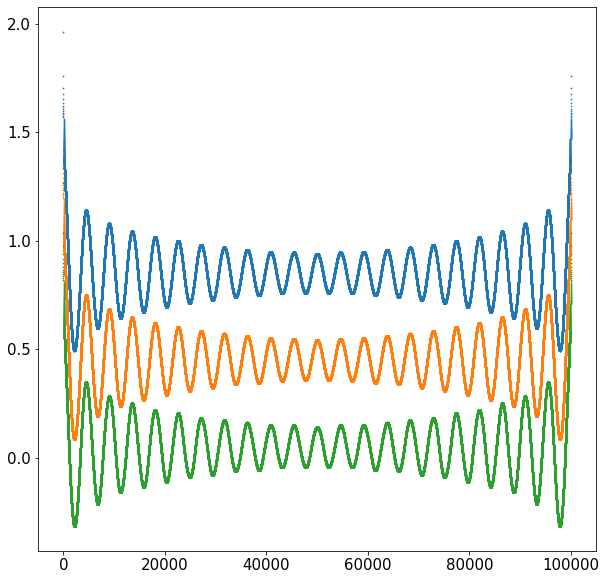

In [219]:
plt.scatter(np.arange(0,len(ptY)),np.fft.ifft(ptY)+0.8, s=0.5)
plt.scatter(np.arange(0,len(ptY2)),np.fft.ifft(ptY2)+0.4, s=0.5)
plt.scatter(np.arange(0,len(ptY2)),np.fft.ifft(pYp), s=0.5)
plt.show()

[0.18638565 0.18637551 0.18646285 ... 0.21555853 0.21558628 0.21562679]


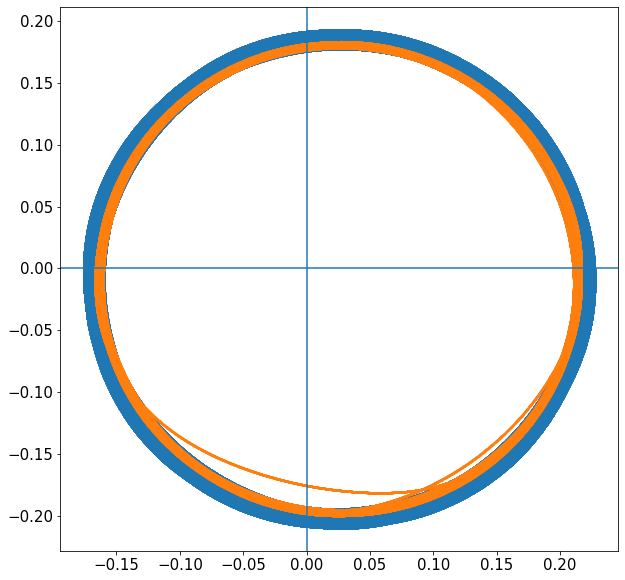

In [217]:
alt_i_filtered = np.sqrt(alt_f_q*alt_f_q + alt_f_p*alt_f_p)
alt_i_filtered2 = np.sqrt(alt_f_q2*alt_f_q2 + alt_f_p2*alt_f_p2)

plt.scatter(p,q)
plt.scatter(alt_f_p,alt_f_q,s=0.9)
plt.axhline(y=0)
plt.axvline(x=0)
print(alt_i_filtered)



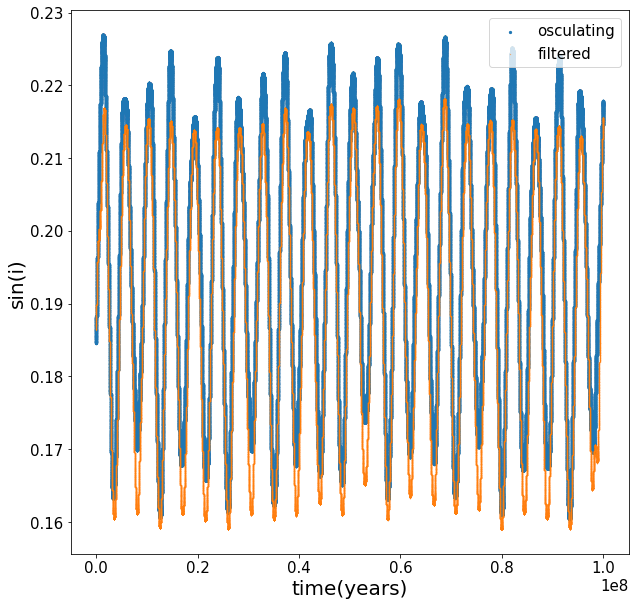

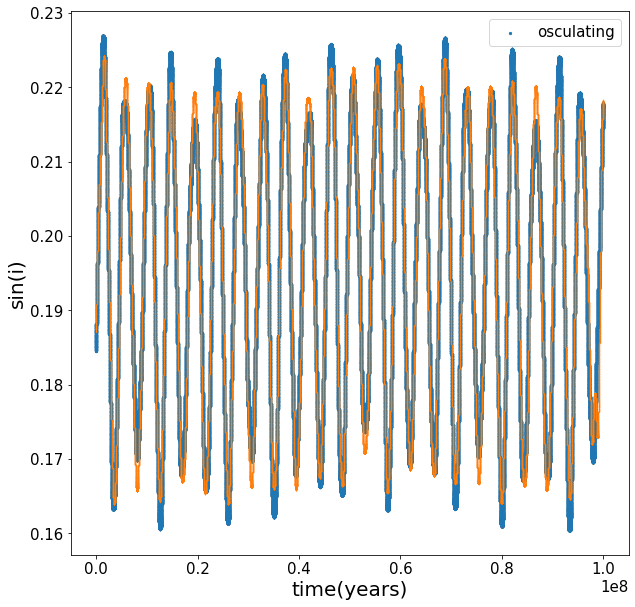

In [218]:
plt.scatter(t,sini,s=5,label='osculating')
plt.scatter(t,alt_i_filtered,s=0.05,label='filtered')
#plt.axhline(y=np.sin(11.2669*np.pi/180))
#plt.axhline(y=np.sin(11.4669*np.pi/180))
#plt.axhline(y=np.sin(11.0669*np.pi/180))
plt.xlabel('time(years)')
plt.ylabel('sin(i)')
plt.legend()
plt.show()

plt.scatter(t,sini,s=5,label='osculating')
plt.scatter(t,alt_i_filtered2,s=0.05)
#plt.axhline(y=np.sin(11.2669*np.pi/180))
#plt.axhline(y=np.sin(11.4669*np.pi/180))
#plt.axhline(y=np.sin(11.0669*np.pi/180))
plt.xlabel('time(years)')
plt.ylabel('sin(i)')
plt.legend()
plt.show()


#plt.xlim([0,1e8])

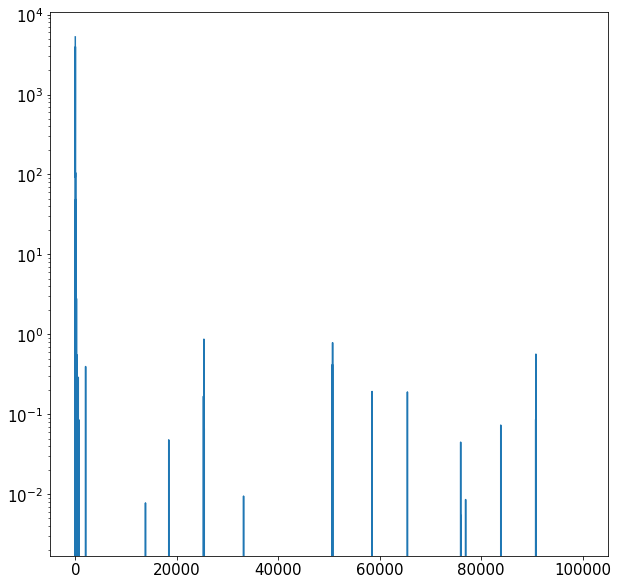

In [184]:
from scipy import signal

#plt.scatter(t,ecc)
plt.plot(Yp)
#plt.xscale('log')
plt.yscale('log')
plt.show()

200001 200001


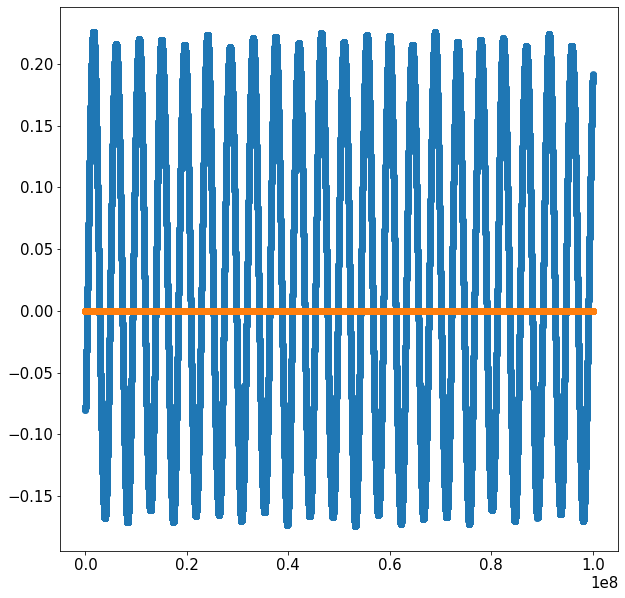

200001 200001


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  
/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


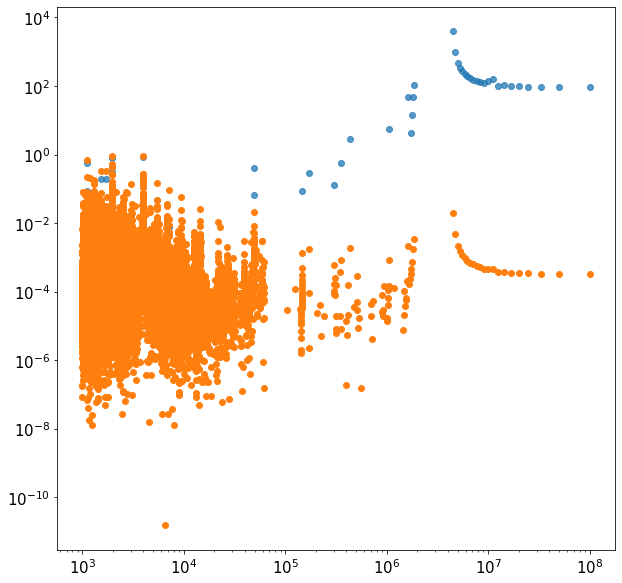

In [191]:
n = len(p)
freq2 = np.fft.fftfreq(n,d=dt)
b, a = signal.butter(1, 0.1, btype='highpass')
zi = signal.lfilter_zi(b, a)
print(len(p),len(freq2))
z, _ = signal.lfilter(b, a, p, zi=zi*p[0])
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
y = signal.filtfilt(b, a, p)
plt.figure()
plt.scatter(t, p, alpha=0.75)
#plt.scatter(t, z)
#plt.scatter(t, z2)
plt.scatter(t, y)
plt.show()
print(len(p),len(z))
plt.scatter(1/freq2, np.fft.fft(p), alpha=0.75)
#plt.scatter(1/freq2, np.fft.fft(z))
#plt.scatter(1/freq2, np.fft.fft(z2))
plt.scatter(1/freq2, np.fft.fft(y))
plt.yscale('log')
plt.xscale('log')
plt.show()

3.219983900080499e-06 3.3199834000829994e-06 3.4699826500867495e-06
100001 100001


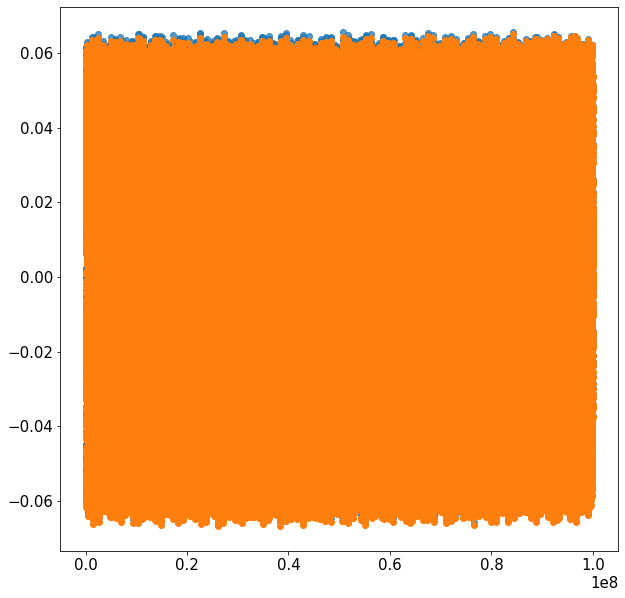

[ 0.00931744  0.01367678  0.01859104 ... -0.0373803  -0.03419653
 -0.03250628]
200001 100001


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


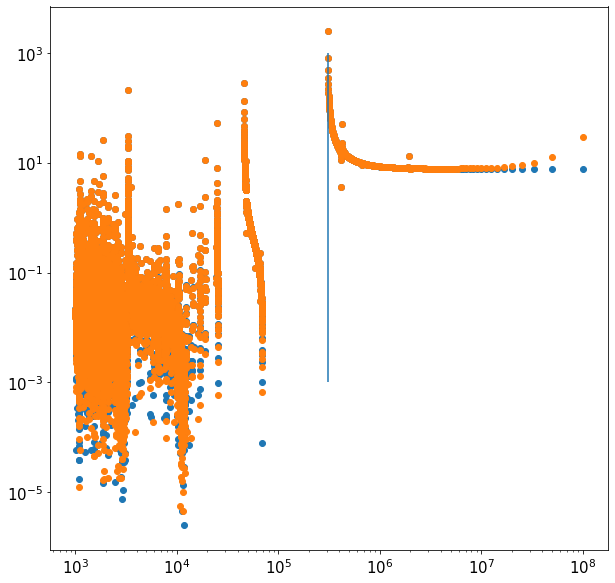

In [192]:

print(freq[ihjmax-5], freq[ihjmax+5],freq[ihjmax+20])
b, a = signal.butter(1, [freq[ihjmax-5],freq[ihjmax+5]], btype='bandstop')
zi = signal.lfilter_zi(b, a)
print(len(pYp),len(freq))
z, _ = signal.lfilter(b, a, hj, zi=zi*hj[0])
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
y = signal.filtfilt(b, a, hj)
plt.figure()
plt.scatter(t, hj, alpha=0.75)
#plt.scatter(t, z)
#plt.scatter(t, z2)
plt.scatter(t, y)
#plt.yscale('log')
#plt.xscale('log')
plt.show()

print(y)

print(len(hj),len(freq))
new = np.fft.fft(y)
plt.scatter(1/freq2,np.fft.fft(hj))
plt.scatter(1/freq2,new)
plt.vlines(1/freq[ihjmax],ymin=1e-3,ymax=1e3)
plt.xscale('log')
plt.yscale('log')

327 3.2699836500817495e-06 305811.9266055046
[[2.00000000e+00 2.98452222e+00 7.30848487e+00 ... 3.00000000e+00
  3.00000000e+00 5.00000000e+00]
 [1.12949511e+00 2.01320891e+00 2.47671391e+00 ... 1.76641868e-03
  1.84077105e-03 1.87221149e-03]
 [1.00000000e+00 3.40154778e+01 3.76915151e+01 ... 9.99890000e+04
  9.99920000e+04 9.99950000e+04]
 [3.00000000e+00 3.70000000e+01 4.50000000e+01 ... 9.99920000e+04
  9.99950000e+04 1.00000000e+05]]


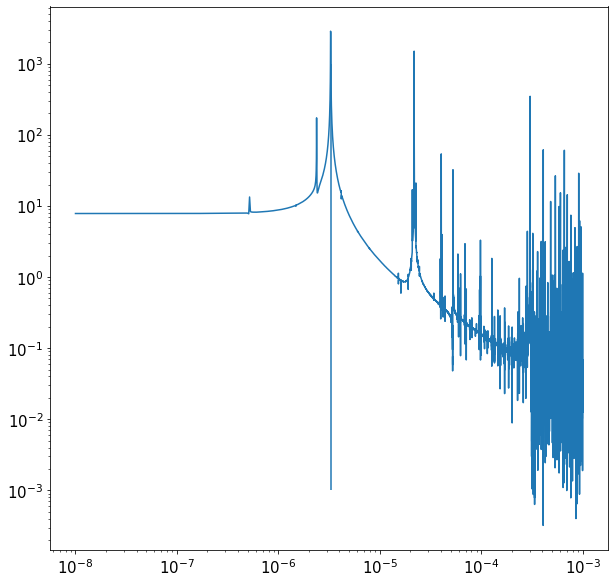

In [187]:
from scipy.signal import peak_widths,find_peaks
print(ihjmax, freq[ihjmax],1/freq[ihjmax])
peaks, _ = find_peaks(pYpj)
plt.plot(freq[1:],pYhj[1:])
plt.vlines(freq[ihjmax],ymin=1e-3,ymax=1e3)
results_full = peak_widths(pYpj, peaks, rel_height=5)
print(np.array(results_full))
#plt.hlines(*results_full[1:], color="C3")
plt.yscale('log')
plt.xscale('log')